In [1]:
import sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import matplotlib.pyplot as plt

from nnlocallinear import NLS, LLS, NNPredict

import lime
from lime import lime_text
from sklearn.pipeline import make_pipeline

In [2]:
from ExplainText import ExplainText
from ExplainText import SparseMatrix

# Preparing data

In [3]:
categories = ['alt.atheism', 'soc.religion.christian']
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=categories)
class_names = ['atheism', 'christian']
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
train_vectors = vectorizer.fit_transform(newsgroups_train.data)
test_vectors = vectorizer.transform(newsgroups_test.data)
train_vectors = train_vectors.toarray()
test_vectors = test_vectors.toarray()

In [4]:
names_features = np.array(vectorizer.get_feature_names())

In [5]:
len(vectorizer.get_feature_names())

23035

# Training the NLS

In [6]:
parameters = {
        'model__es_give_up_after_nepochs': [20]
        , 'model__hidden_size': [100, 250, 500]
        , 'model__num_layers': [1, 3, 5]
    }

comb_parameters = [{
        'es_give_up_after_nepochs': 20
        , 'hidden_size': 100
        , 'num_layers': 1
        , 'n_classification_labels': 2,

    }
        ]

In [7]:

for parameter in comb_parameters:
    model = NLS(
        verbose=0
        , es=True
        , gpu=True
        , scale_data=False
        , varying_theta0=False
        , fixed_theta0=True
        , dataloader_workers=0
        # , with_mean=False
        , **parameter
    ) 
    model.fit(x_train=train_vectors, y_train=newsgroups_train.target)

## Testing model

In [8]:
test_vectors = test_vectors
pred = model.predict(test_vectors)
print('Score:', sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary'))

Score: 0.9572649572649573


# Explaining a Document

In [44]:
idx = 40
# newsgroups_test.data[idx]
print('Document id: %d' % idx)
# print(model.predict(test_vectors))
print('Probability(christian) =', model.predict_proba([test_vectors[idx]]))

print('True class: %s' % class_names[newsgroups_test.target[idx]])
print('True class number:',newsgroups_test.target[idx] )
print('Text:')
print(newsgroups_test.data[idx])
x_explain = test_vectors[idx].reshape(1, -1)
document_explain = newsgroups_test.data[idx]

Document id: 40
Probability(christian) = [[1.6276714e-05 9.9998367e-01]]
True class: christian
True class number: 1
Text:
From: hudson@athena.cs.uga.edu (Paul Hudson Jr)
Subject: Re: FAQ essay on homosexuality
Organization: University of Georgia, Athens
Lines: 201

In article <May.11.05.06.28.1993.5458@geneva.rutgers.edu> hedrick@geneva.rutgers.edu writes:

>this came from.  Here's his response: Kinsey (see below) is the source
>of the figure 10 percent.

There was an article in USA today a few months ago showing the results
of a study that actually only about 1% were homosexual.  I saw another
figure that listed 2% as the figure.  Of course, even if it were 99%
that would have little bearing on whether or not it is a sinful behavior.
How many people have commited other acts of fornication?  How many
people have lied or sinned in other ways?

>But in all fairness, the "shameless" nature of their acts is a
>reflection of the general spiritual state of the people, and not a
>specific fea

In [43]:
idx = 40
document_explain = newsgroups_test.data[idx]
print('classe:', newsgroups_test.target[idx])
print(document_explain)

classe: 1
From: hudson@athena.cs.uga.edu (Paul Hudson Jr)
Subject: Re: FAQ essay on homosexuality
Organization: University of Georgia, Athens
Lines: 201

In article <May.11.05.06.28.1993.5458@geneva.rutgers.edu> hedrick@geneva.rutgers.edu writes:

>this came from.  Here's his response: Kinsey (see below) is the source
>of the figure 10 percent.

There was an article in USA today a few months ago showing the results
of a study that actually only about 1% were homosexual.  I saw another
figure that listed 2% as the figure.  Of course, even if it were 99%
that would have little bearing on whether or not it is a sinful behavior.
How many people have commited other acts of fornication?  How many
people have lied or sinned in other ways?

>But in all fairness, the "shameless" nature of their acts is a
>reflection of the general spiritual state of the people, and not a
>specific feature of homosexuality.

Why isn't it a specific feature of homosexuality?  Paul describes
"men with men working 

# Generating an Explanation

In [45]:
exp_NLS = ExplainText(model, class_names=['atheism', 'christian'], names_features=names_features)
# dict_exp = exp.get_text_explanation(x_explain, document=document_explain)

In [54]:
dict_exp = exp_NLS.get_text_explanation(x_explain, document=document_explain)

<BarContainer object of 10 artists>

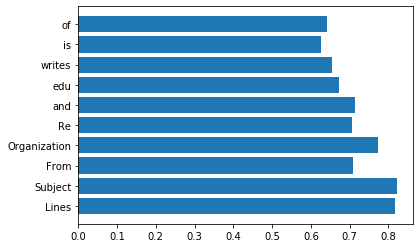

In [58]:
plt.barh(dict_exp['words'], dict_exp['betas_document'])

<BarContainer object of 10 artists>

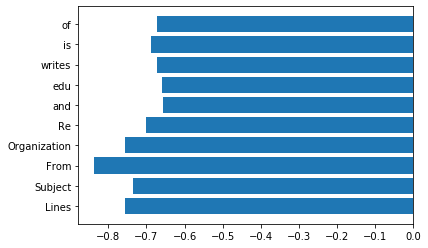

In [60]:
plt.barh(dict_exp['words'], dict_exp['betas_document_neg'])

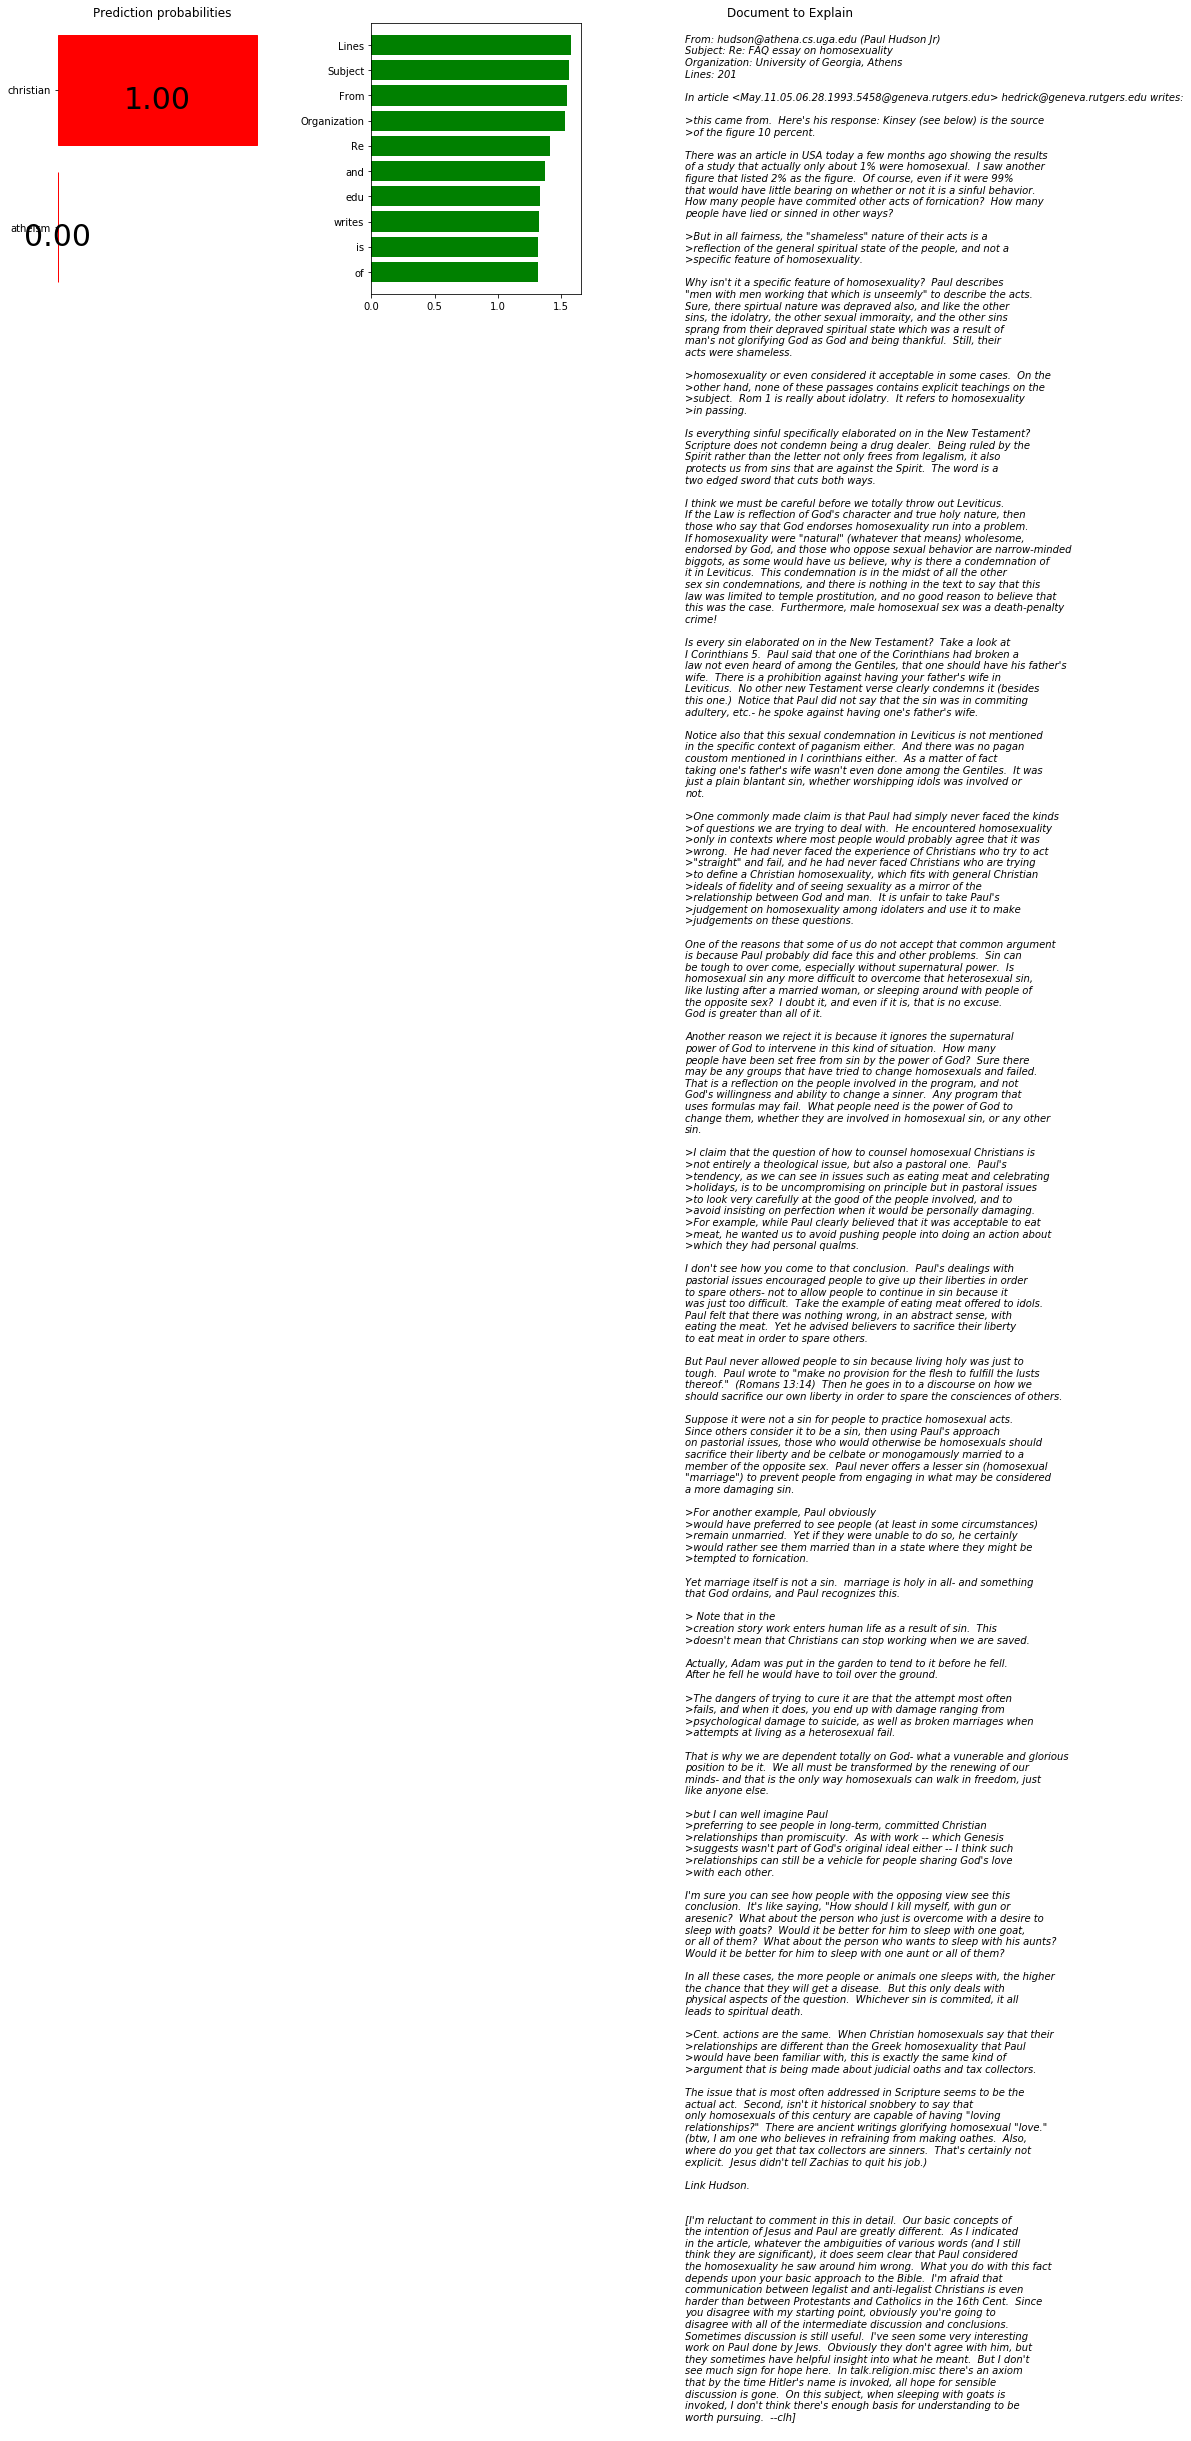

In [47]:
plot_exp = exp_NLS.explain_graphical(x_explain, document=document_explain)

# Explaining Lime

In [48]:
sparse_matrix = SparseMatrix()

In [49]:
c_1 = make_pipeline(vectorizer, sparse_matrix, model)

In [50]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [51]:
exp = explainer.explain_instance(newsgroups_test.data[idx], c_1.predict_proba, num_features=10)

In [52]:
exp.as_list()

[('sin', 0.0076343574176795555),
 ('of', 0.005992197076133569),
 ('Paul', 0.005875928942185696),
 ('God', 0.005719824631912893),
 ('Christians', 0.005270007902627766),
 ('and', 0.00511493416048151),
 ('depraved', 0.005047038116778353),
 ('this', 0.0049138544728272735),
 ('it', -0.0014507158609931507),
 ('people', -0.0001129848337038771)]

In [53]:
exp.show_in_notebook(text=False)

## Training a NN model

In [29]:
for parameter in comb_parameters:
    model_1 = NNPredict(
        verbose=1
        , es=True
        , gpu=True
        , dataloader_workers=0
        , **parameter
    )
    model_1.fit(x_train=train_vectors, y_train=newsgroups_train.target)

Validation loss did not improve after 20 tries. Stopping
Elapsed time: 56.119125843048096


In [30]:
pred = model_1.predict(test_vectors)
print('Score:', sklearn.metrics.f1_score(newsgroups_test.target, pred, average='binary'))

Score: 0.9486552567237164


In [31]:
c = make_pipeline(vectorizer, sparse_matrix, model_1) 

In [32]:
c.predict_proba([newsgroups_test.data[idx]])

array([[0.32385722, 0.67614275]], dtype=float32)

In [33]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)
class_names

['atheism', 'christian']

In [34]:
exp = explainer.explain_instance(newsgroups_test.data[idx], c.predict_proba, num_features=10)

In [35]:
exp.as_list()

[('unm', -0.32852733995395716),
 ('net', 0.14427121888729844),
 ('Darwin', -0.13440529885856972),
 ('asking', 0.11913934220936696),
 ('email', 0.11706869206915786),
 ('Fish', -0.11091792355369791),
 ('NNTP', -0.10884995985004668),
 ('New', 0.1040420014662077),
 ('please', 0.10281087637548252),
 ('Hello', 0.09481923014461148)]

In [36]:
exp.show_in_notebook(text=False)